In [1]:
import pandas as pd

import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch
import itertools
from torch.optim import SGD

from wildlife_tools.train import ArcFaceLoss, BasicTrainer, set_seed
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import ImageDataset


/Users/ash/phd/guppies/coding/wildlife-tools/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load metadata
PT_CSV = '/Users/ash/phd/guppies/coding/wildlife-tools/exploring/top_10_individuals.csv'
PT_images = '/Users/ash/phd/guppies/data/test_imgs_blacked'
df = pd.read_csv(PT_CSV)
# df['path'] = df['path'].str.replace('.JPG', '.png', case=False)
# df.to_csv(PT_CSV, index=False)
df.head()

,identity,path,date
0,63498,1706/Lower Lalaja/29A/DCIM/121D7100/DSC_8870.png,2017-06-29
1,63498,1803/LL/26B/123D7100/DSC_3857.png,2018-03-26
2,63498,1804/LL/27B/DSC_5389.png,2018-04-27
3,63498,1802/LL/26B/DSC_0428.png,2018-02-26
4,63498,1806/LL/28A/100D7100/DSC_9352.png,2018-06-28


In [3]:

# Define image transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match MegaDescriptor-L-384 input
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
dataset = ImageDataset(df, root=PT_images, transform=transform)


In [7]:


# Load the MegaDescriptor model
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', pretrained=True, num_classes=0)

# Define the loss function
objective = ArcFaceLoss(
    num_classes=dataset.num_classes,
    embedding_size=backbone.num_features,
    margin=0.5,
    scale=64
)

# Define the optimizer
params = itertools.chain(backbone.parameters(), objective.parameters())
optimizer = SGD(params=params, lr=0.001, momentum=0.9)

# Set the seed for reproducibility
set_seed(0)

# Initialize the trainer
trainer = BasicTrainer(
    dataset=dataset,
    model=backbone,
    objective=objective,
    optimizer=optimizer,
    epochs=5,
    device='cpu'  # Use 'cpu' if CUDA is not available
)

In [8]:
# Start training
trainer.train()

Epoch 4: 100%|████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.24s/it]


In [9]:

extractor = DeepFeatures(backbone, device='cpu')

# Extract features
features = extractor(dataset)


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.85s/it]


In [10]:
assert len(features) == len(dataset)
assert tuple(features.features.shape) == (len(dataset), 768)

In [11]:
# Convert embeddings to NumPy array
embeddings = features.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = features.labels_string  # Assuming labels are stored here

In [12]:
print(labels[:10])  # Print first 10 labels for verification
print(len(set(labels))) #number of individuals
print(embeddings.shape)

['63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498'
 '63498']
10
(304, 768)


In [13]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


python(7050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


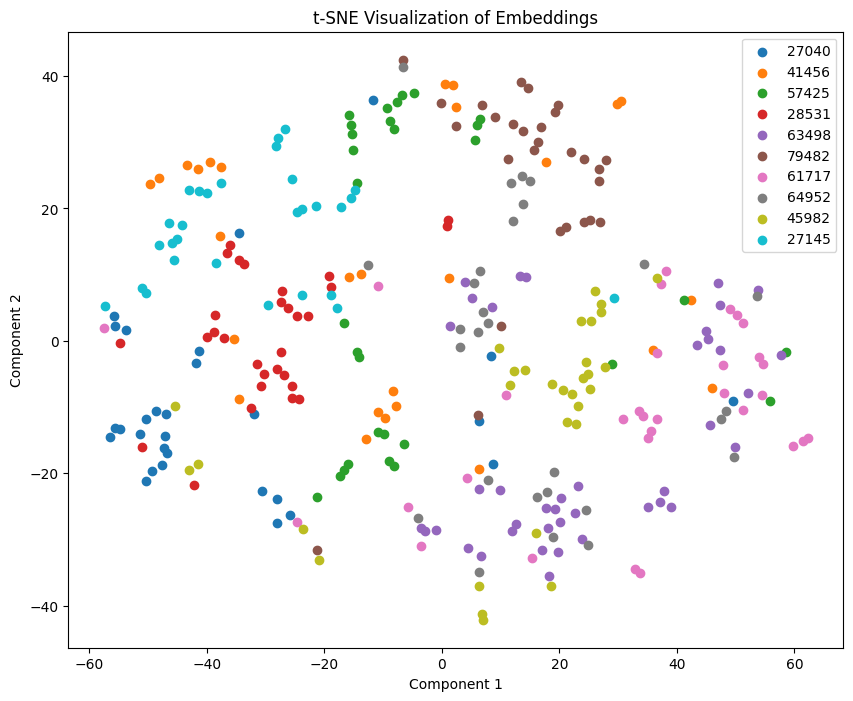

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [15]:
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier
import numpy as np

# Split dataset into query and database sets
query_df = df.sample(frac=0.2, random_state=42)
database_df = df.drop(query_df.index)

# Create ImageDataset instances
query_dataset = ImageDataset(query_df, root=PT_images, transform=transform)
database_dataset = ImageDataset(database_df, root=PT_images, transform=transform)

# Extract features
query_features = extractor(query_dataset)
database_features = extractor(database_dataset)

# Compute cosine similarity
similarity_function = CosineSimilarity()
similarity = similarity_function(query_features, database_features)

# Perform 1-NN classification
classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string)
predictions = classifier(similarity)

# Evaluate accuracy
accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(predictions))
print(f'1-NN Classification Accuracy: {accuracy:.2%}')


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.16s/it]

1-NN Classification Accuracy: 60.66%


In [15]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")

Average similarity within the same identity: 0.7948
Average similarity between different identities: 0.7660


In [16]:
print(same_identity_sims.values())
print(different_identity_sims.values())

dict_values([[np.float32(0.7252621), np.float32(0.7069551), np.float32(0.80846786), np.float32(0.8556588), np.float32(0.77243197), np.float32(0.6758913), np.float32(0.841206), np.float32(0.8552578), np.float32(0.74855185), np.float32(0.8079814), np.float32(0.8007363), np.float32(0.76522636), np.float32(0.8151696), np.float32(0.7915647), np.float32(0.88492906), np.float32(0.88859224), np.float32(0.7477944), np.float32(0.54616886), np.float32(0.75260293), np.float32(0.77178526), np.float32(0.821684), np.float32(0.7799909), np.float32(0.7539453), np.float32(0.66909146), np.float32(0.7762506), np.float32(0.76117134), np.float32(0.7707613), np.float32(0.87972856), np.float32(0.76657236), np.float32(0.7889085), np.float32(0.7634779), np.float32(0.807747), np.float32(0.8654919), np.float32(0.7515407), np.float32(0.7453092), np.float32(0.82194805), np.float32(0.72874343), np.float32(0.7945656), np.float32(0.868373), np.float32(0.77339613), np.float32(0.8515327), np.float32(0.86067593), np.floa

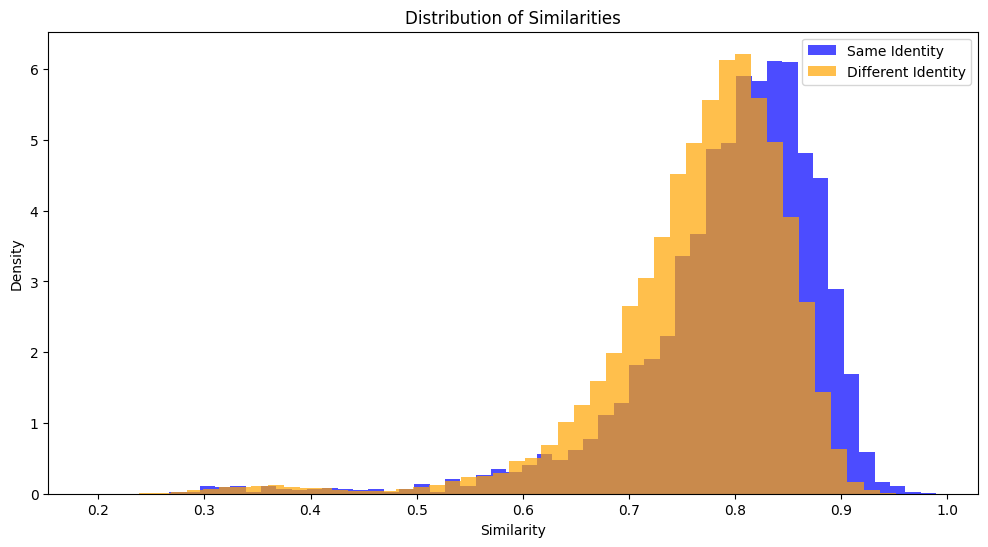

In [17]:
plt.figure(figsize=(12, 6))

# Flatten the lists of similarities
same_identity_flat = [sim for sims in same_identity_sims.values() for sim in sims]
different_identity_flat = [sim for sims in different_identity_sims.values() for sim in sims]

# Plot histograms
plt.hist(same_identity_flat, bins=50, alpha=0.7, label='Same Identity', color='blue', density=True)
plt.hist(different_identity_flat, bins=50, alpha=0.7, label='Different Identity', color='orange', density=True)

# Add labels and legend
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.legend()

plt.show()